# NESTML Izhikevich tutorial

Introduction
------------

The aim of this exercise is to obtain familiarity with NESTML by completing a partial model of the Izhikevich neuron [1].


Prerequisites
-------------

You need to have a working NEST Simulator and NESTML installation, see [Installing NESTML](https://nestml.readthedocs.io/en/latest/installation.html).

You need to be able to run NESTML to generate and build model code. NESTML can be used from the command line, and via a Python API. The latter will be used in this notebook. See [Running NESTML](https://nestml.readthedocs.io/en/latest/running.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

### Paths

We assume here that we will generate code in a temporary directory `/tmp/nestml-component`. You can also create a unique temporary path using the [Python tempfile module](https://docs.python.org/3/library/tempfile.html).


The Izhikevich model
--------------------

A simple model for spiking neurons that nevertheless can exhibit a wide variety of dynamical behaviour, depending on its parameter values [1]. It is defined as follows:

\begin{align}
\frac{dv}{dt} &= 0.04 v^2 + 5 v + 140 - u + I\\
\frac{du}{dt} &= a (b v - u)
\end{align}

State update:

\begin{align}
   &\text{if}\;\; v \geq V_{th}:\\
   &\;\;\;\; v \text{ is set to } c\\
   &\;\;\;\; u \text{ is incremented by } d\\
   & \, \\
   &v \text{ jumps on each spike arrival by the weight of the spike}
\end{align}

Example parameters for regular spiking (the meaning of these parameters is described in detail in the paper [1]; see also Task 2 below): 

\begin{align}
a&=0.02\\
b&=0.2\\
c&=-65~\text{mV}\\
d&=8
\end{align}


Task 1: Finish the model
------------------------

In the file [`izhikevich_task.nestml`](https://raw.githubusercontent.com/nest/nestml/master/doc/tutorials/izhikevich/izhikevich_task.nestml), only a subset of the parameters, state equations and update block is implemented.

Open the file in a text editor and finish the partially-completed model.

For reference, the solution is included as [`izhikevich_solution.nestml`](https://raw.githubusercontent.com/nest/nestml/master/doc/tutorials/izhikevich/izhikevich_solution.nestml).

### NESTML code generation

Assume that our NESTML input model is at `izhikevich_solution.nestml`. To generate code and build a dynamic library that can be loaded as a user module in NEST Simulator:

In [2]:
# generate and build code
module_name, neuron_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("izhikevich_solution.nestml")

[12,izhikevich_tutorial_nestml, WARNING, [12:8;12:17]]: Variable 'a' has the same name as a physical unit!
[13,izhikevich_tutorial_nestml, WARNING, [15:8;15:17]]: Variable 'd' has the same name as a physical unit!
[17,izhikevich_tutorial_nestml, WARNING, [12:8;12:17]]: Variable 'a' has the same name as a physical unit!
[18,izhikevich_tutorial_nestml, WARNING, [15:8;15:17]]: Variable 'd' has the same name as a physical unit!
[23,izhikevich_tutorial_nestml, WARNING, [12:8;12:17]]: Variable 'a' has the same name as a physical unit!
[24,izhikevich_tutorial_nestml, WARNING, [15:8;15:17]]: Variable 'd' has the same name as a physical unit!
CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is AppleClang 15.0.0.15000309

Check the generated log output for any potential error messages or warnings.

### Instantiate model in NEST Simulator and run
The generated extension module can be loaded using ``nest.Install()``.

Using the PyNEST API, the model can be instantiated and simulated in NEST. The following code will create one instance of the neuron model (`nest.Create("izhikevich_tutorial")`), inject a constant current and run the simulation for 250 ms.


Apr 04 10:44:22 Install [Info]: 
    loaded module nestml_a5f0f33d08cf49c7b7df45600e9b750e_module

Apr 04 10:44:22 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Apr 04 10:44:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 250
    Number of OpenMP threads: 1
    Not using MPI

Apr 04 10:44:22 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/2j/fb047q1177v9f56f_jktrb4c0000gn/T/ipykernel_57036/1245292433.py:33: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


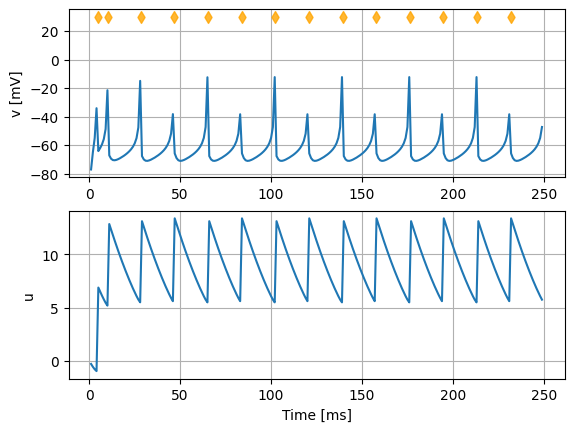

In [3]:
nest.set_verbosity("M_ALL")
nest.ResetKernel()

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)

neuron = nest.Create(neuron_model_name)
voltmeter = nest.Create("voltmeter")

voltmeter.set({"record_from": ["v", "u"]})
nest.Connect(voltmeter, neuron)

cgs = nest.Create('dc_generator')
cgs.set({"amplitude": 25.})
nest.Connect(cgs, neuron)

sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)

nest.Simulate(250.)

spike_times = nest.GetStatus(sr, keys='events')[0]['times']

fig, ax = plt.subplots(nrows=2)
ax[0].plot(voltmeter.get("events")["times"], voltmeter.get("events")["v"])
ax[1].plot(voltmeter.get("events")["times"], voltmeter.get("events")["u"])
ax[0].scatter(spike_times, 30 * np.ones_like(spike_times), marker="d", c="orange", alpha=.8, zorder=99)
for _ax in ax:
    _ax.grid(True)
ax[0].set_ylabel("v [mV]")
ax[1].set_ylabel("u")
ax[-1].set_xlabel("Time [ms]")
fig.show()

Task 2: Parameter space exploration
-----------------------------------

Perform a parameter space exploration to reproduce the bottom eight panels from [1], figure 2.

## References

[1] Eugene M. Izhikevich, "Simple Model of Spiking Neurons", IEEE Transactions on Neural Networks, Vol. 14, No. 6, November 2003

## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
